# MODEL, DATA GENERATOR, TRAINING

### You are requested to go through this section before starting coding. 

 - 1) First of all, this ipynb file is the second part of the project. The first one was for preprocessing the data. So only after completing the 1st notebook you will be able to run this notebook because I have manywhere used some saved file which I have saved previously (using pickle).
 -2) You already have seen that there are many cell containing the path of my google-colab.But you have to keep track of that. You can take help ( though it is barely helpful) from the ipynb files used with the py files. Which you can find out side this folder.
 - 3) Sometimes I have used some codes not related to the previous cell. THen, you probably skip it, because I wanted to see something deeper from that.
  - 4) I have found some portion of the codes in github and some of it is modified also. So I should give credit to them, But unfortunately I can't get the source from where I was taken help. So, pardon me for that.

In [2]:
%cd /content/drive/MyDrive/BDA2020_MN/Projects/new_project


/content/drive/MyDrive/BDA2020_MN/Projects/new_project


In [5]:
!mv text_processing.py utils/

In [ ]:
# !pip install pyyaml h5py  

In [ ]:
!pip install ipython-autotime

%load_ext autotime

time: 169 µs (started: 2021-06-13 16:48:12 +00:00)


In [ ]:
#importing the libraries
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from keras.preprocessing import image
from keras.models import Model
# from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from keras.utils import np_utils
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import cv2
import random
import pandas as pd

time: 4.55 s (started: 2021-06-13 16:48:15 +00:00)


In [ ]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding

time: 4.3 ms (started: 2021-06-13 16:48:21 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 33.2 s (started: 2021-06-13 16:48:24 +00:00)


In [ ]:
#converting the text files to pandas dataframe
# image_tokens=pd.read_csv("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/Flickr8k_text/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/Flickr8k_text/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/Flickr8k_text/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/Flickr8k_text/Flickr_8k.devImages.txt",names=["img_id"])


# captions
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_captions.pickle","rb")
train_captions=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/test_captions.pickle","rb")
test_captions=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_captions.pickle","rb")
validation_captions=pickle.load(pickle_in)

# dictionaries
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/words_to_indices.pickle","rb")
words_to_indices=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/indices_to_words.pickle","rb")
indices_to_words=pickle.load(pickle_in)

# texts
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_encoded_captions.pickle","rb")
train_encoded_captions=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/test_encoded_captions.pickle","rb")
test_encoded_captions=pickle.load(pickle_in)                                                               ## I intentionally did it later 
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_encoded_captions.pickle","rb")
validation_encoded_captions=pickle.load(pickle_in)                                                         ## I intentionally did it later 

# features
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_features.pickle","rb")
train_features=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/test_features.pickle","rb")
test_features=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_features.pickle","rb")
validation_features=pickle.load(pickle_in)

time: 6.93 s (started: 2021-06-13 16:49:55 +00:00)


## Model

In [ ]:
#model
max_length=40
vocab_size=6329

input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 256)      1620224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

## Data Generator for Modelling

In [ ]:
# def data_generator(train_encoded_captions,train_features,num_of_photos):
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=np.copy(train_encoded_captions[img_id][i][0:j].tolist())
        next_word=np.copy(train_encoded_captions[img_id][i][j])
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=np_utils.to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield ((np.asarray(X1), np.asarray(X2)), np.asarray(Y))
      X1, X2, Y = list(), list(), list()
      n=0

time: 16.9 ms (started: 2021-06-13 16:50:39 +00:00)


In [ ]:
#  model.fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None,
#  validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, 
#  use_multiprocessing=False, shuffle=True, initial_epoch=0)
# Fits the model on data yielded batch-by-batch by a Python generator.

# DEPRECATED:
#   Model.fit now supports generators, so there is no longer any need to use
# this endpoint


# model.fit(x=None, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, 
#           validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, 
#           steps_per_epoch=None, validation_steps=None, validation_batch_size=None,
#           validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False)



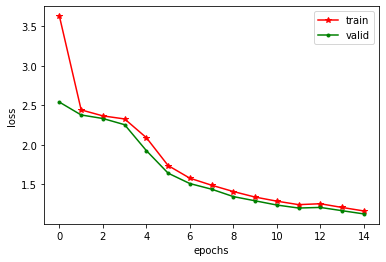

time: 207 ms (started: 2021-06-13 16:53:27 +00:00)


In [ ]:
## Just to show something interesting I haveput this before traing.Though I trained it before and got this result.

## Training with validation data and validation with validation data 

tll=[[3.628364324569702],
 [2.4433629512786865],
 [2.367478847503662],
 [2.3288376331329346],
 [2.091864824295044],
 [1.73914635181427],
 [1.5792171955108643],
 [1.4905771017074585],
 [1.4104931354522705],
 [1.3405146598815918],
 [1.2887576818466187],
 [1.2447237968444824],
 [1.2560333013534546],
 [1.2092037200927734],
 [1.1649588346481323]]

vll=[[2.5417943000793457],
 [2.3792364597320557],
 [2.3344595432281494],
 [2.2560131549835205],
 [1.9278911352157593],
 [1.642787218093872],
 [1.5114091634750366],
 [1.4400147199630737],
 [1.3465205430984497],
 [1.2933061122894287],
 [1.2397526502609253],
 [1.2018401622772217],
 [1.2094342708587646],
 [1.1682108640670776],
 [1.1273598670959473]]

plt.plot(tll,"r*-",label="train")
plt.plot(vll,"g.-",label="valid")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

No handles with labels found to put in legend.


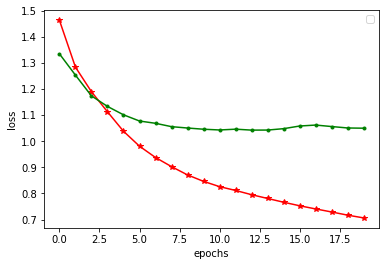

time: 216 ms (started: 2021-06-13 16:54:10 +00:00)


In [ ]:
## 1st trainign with validation simultaniously

a=[[1.4645437002182007], [1.2847044467926025], [1.1903520822525024], [1.1132287979125977], [1.0386292934417725], [0.9812448620796204], [0.9378303289413452], [0.9028103351593018], [0.8710004091262817], [0.846245527267456], [0.8260873556137085], [0.8114045858383179], [0.7951233386993408], [0.7806732654571533], [0.7661908268928528], [0.7526741027832031], [0.7405298352241516], [0.7288129925727844], [0.7165934443473816], [0.7060975432395935]]
b=[[1.3357585668563843], [1.2539596557617188], [1.1743152141571045], [1.133941888809204], [1.1016947031021118], [1.077876091003418], [1.0691213607788086], [1.0562130212783813], [1.0509953498840332], [1.0463978052139282], [1.043529748916626], [1.0465686321258545], [1.0429508686065674], [1.0432004928588867], [1.048551082611084], [1.0587276220321655], [1.0623588562011719], [1.0566647052764893], [1.0511550903320312], [1.0503252744674683]]

plt.plot(a,"r*-")
plt.plot(b,"g.-")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


## Training

In [ ]:
# model.load_weights('/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/LSTM_Optimal_Valid_Weights/my_weights')

## question  why this path didn't  work 

time: 1.31 ms (started: 2021-06-13 16:59:35 +00:00)


In [ ]:
# Restore the weights
model.load_weights('/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/LSTM_Model_Weights/my_weights')

time: 3.38 s (started: 2021-06-13 17:01:19 +00:00)


In [ ]:
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_loss_list.pickle","rb")
train_loss_list=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_loss_list.pickle","rb")
validation_loss_list=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_accuracy_list.pickle","rb")
train_accuracy_list=pickle.load(pickle_in)
pickle_in= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_accuracy_list.pickle","rb")
validation_accuracy_list=pickle.load(pickle_in)

time: 1.01 s (started: 2021-06-13 17:01:32 +00:00)


In [ ]:
# training+validation  [ 12/06/2021]  I ran it from the begening  total 50 epochs
epochs=50
no_of_photos=60
steps1=len(train_encoded_captions)//no_of_photos
steps2=len(validation_encoded_captions)//no_of_photos
# train_loss_list=[]
# validation_loss_list=[]
# train_accuracy_list=[]
# validation_accuracy_list=[]
epoch_completed=0
for i in range(epochs):
  train_generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  validation_generator=data_generator(validation_encoded_captions,validation_features,no_of_photos)
  train_hist=model.fit(train_generator,epochs=1, steps_per_epoch=steps1,verbose=1,validation_data=validation_generator)

  train_loss_list.append(train_hist.history['loss'])
  validation_loss_list.append(train_hist.history['val_loss'])
  train_accuracy_list.append(train_hist.history['accuracy'])
  validation_accuracy_list.append(train_hist.history['val_accuracy'])

  epoch_completed+=1
  print("\n****\n****\n****\n      epoch completed = {}   \n****\n****\n****".format( epoch_completed ))

  if (i+1)%5==0:
    model.save_weights('/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/LSTM_Model_Weights/my_weights')
    print("\n****\n****\n****\n    weight saved for total {} epohcs  \n****\n****\n****".format(epoch_completed))

    pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_loss_list.pickle","wb")                                 
    pickle.dump(train_loss_list,pickle_out)
    pickle_out.close()
    pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_loss_list.pickle","wb")                                  
    pickle.dump(validation_loss_list,pickle_out)
    pickle_out.close()
    pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_accuracy_list.pickle","wb")                                
    pickle.dump(train_accuracy_list,pickle_out)
    pickle_out.close()
    pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_accuracy_list.pickle","wb")                                 
    pickle.dump(validation_accuracy_list,pickle_out)
    pickle_out.close()

  if train_hist.history["val_loss"] < min(validation_loss_list):
    model.save_weights('/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/LSTM_Optimal_Valid_Weights/my_weights')

  if (i+1)%10==0 :
    plt.plot(train_loss_list,"r*-",label="train_loss")
    plt.plot(validation_loss_list,"g.-",label="valid_loss")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    plt.plot(train_accuracy_list,"r*-",label="train_accuracy")
    plt.plot(validation_accuracy_list,"g.-",label="valid_accuracy")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

# Save the weights
model.save_weights('/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/LSTM_Model_Weights/my_weights')
print("\n****\n****\n****\n    weight saved for total {} epohcs  \n****\n****\n****".format(epoch_completed))

pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_loss_list.pickle","wb")                                 
pickle.dump(train_loss_list,pickle_out)
pickle_out.close()
pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_loss_list.pickle","wb")                                  
pickle.dump(validation_loss_list,pickle_out)
pickle_out.close()
pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/train_accuracy_list.pickle","wb")                                
pickle.dump(train_accuracy_list,pickle_out)
pickle_out.close()
pickle_out= open("/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/validation_accuracy_list.pickle","wb")                                 
pickle.dump(validation_accuracy_list,pickle_out)
pickle_out.close()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
train_loss_list

[[2.6151719093322754],
 [1.55910062789917],
 [1.339307188987732],
 [1.269087791442871],
 [1.201745629310608],
 [1.145957589149475],
 [1.0815072059631348],
 [1.0228716135025024],
 [0.9736983180046082],
 [0.931403398513794],
 [1.0469492673873901],
 [0.9079146385192871],
 [0.8712387084960938],
 [0.8469650745391846],
 [0.8286521434783936],
 [0.812182605266571],
 [0.7985184788703918],
 [0.7880774736404419],
 [0.7802340984344482],
 [0.7682550549507141],
 [0.7575913071632385],
 [0.7459341883659363],
 [0.7357221245765686],
 [0.7291755676269531],
 [0.7222946286201477],
 [0.715261697769165],
 [0.7087154388427734],
 [0.742110013961792],
 [0.6997729539871216],
 [0.6892011165618896],
 [0.6811712384223938],
 [0.6747310161590576],
 [0.6696393489837646],
 [0.6662856340408325],
 [0.6647008061408997],
 [0.6599115133285522],
 [0.6505512595176697],
 [0.6421509981155396],
 [0.6357046365737915],
 [0.6305261254310608],
 [0.6274738311767578],
 [0.6264439821243286],
 [0.6280947923660278],
 [0.6243019104003906]

time: 14.8 ms (started: 2021-06-13 17:07:34 +00:00)


In [ ]:
validation_loss_list

[[1.9091464281082153],
 [1.3681374788284302],
 [1.3325724601745605],
 [1.2548264265060425],
 [1.2344316244125366],
 [1.1808831691741943],
 [1.1376410722732544],
 [1.1165965795516968],
 [1.0962728261947632],
 [1.1014821529388428],
 [1.08319890499115],
 [1.0674277544021606],
 [1.06159508228302],
 [1.0614157915115356],
 [1.06067955493927],
 [1.061306357383728],
 [1.0655573606491089],
 [1.067697525024414],
 [1.0622317790985107],
 [1.0666433572769165],
 [1.0666663646697998],
 [1.0711015462875366],
 [1.0619438886642456],
 [1.063240647315979],
 [1.0623817443847656],
 [1.0753401517868042],
 [1.0738096237182617],
 [1.0748193264007568],
 [1.0753463506698608],
 [1.0777615308761597],
 [1.081055998802185],
 [1.0817402601242065],
 [1.0859509706497192],
 [1.088716745376587],
 [1.0982613563537598],
 [1.089967131614685],
 [1.0914103984832764],
 [1.098111867904663],
 [1.1054669618606567],
 [1.1139819622039795],
 [1.1153075695037842],
 [1.1200051307678223],
 [1.1314189434051514],
 [1.1164660453796387],
 

time: 5.82 ms (started: 2021-06-13 17:07:39 +00:00)


In [ ]:
train_accuracy_list

[[0.6662333607673645],
 [0.7299675345420837],
 [0.7574854493141174],
 [0.7629239559173584],
 [0.7695623636245728],
 [0.7743700742721558],
 [0.7819803357124329],
 [0.7884905934333801],
 [0.7937307953834534],
 [0.7983256578445435],
 [0.7823939919471741],
 [0.8014547228813171],
 [0.8060837388038635],
 [0.8092316389083862],
 [0.8117794990539551],
 [0.813649594783783],
 [0.8150734901428223],
 [0.8160957098007202],
 [0.8170068264007568],
 [0.8184282183647156],
 [0.8198666572570801],
 [0.8213205337524414],
 [0.82268887758255],
 [0.8233726620674133],
 [0.824465811252594],
 [0.8254683613777161],
 [0.8262179493904114],
 [0.8205077052116394],
 [0.8273162245750427],
 [0.8290307521820068],
 [0.8303743600845337],
 [0.8313205242156982],
 [0.8320136666297913],
 [0.8325085639953613],
 [0.8326897621154785],
 [0.833431601524353],
 [0.8348811864852905],
 [0.8362606763839722],
 [0.8372837901115417],
 [0.8384393453598022],
 [0.8387914299964905],
 [0.8386572599411011],
 [0.8382555842399597],
 [0.838910281658

time: 5.1 ms (started: 2021-06-13 17:07:42 +00:00)


In [ ]:
validation_accuracy_list

[[0.6736164689064026],
 [0.7592040300369263],
 [0.7573077082633972],
 [0.7672595977783203],
 [0.7686752080917358],
 [0.7776495814323425],
 [0.7835683822631836],
 [0.7871367335319519],
 [0.7904754281044006],
 [0.7894284129142761],
 [0.7926121950149536],
 [0.7965918779373169],
 [0.7991719841957092],
 [0.7996420860290527],
 [0.8010149598121643],
 [0.8014903664588928],
 [0.8018001914024353],
 [0.7997702956199646],
 [0.8016773462295532],
 [0.8023344278335571],
 [0.8026869893074036],
 [0.8023771643638611],
 [0.8029914498329163],
 [0.8031196594238281],
 [0.8042948842048645],
 [0.8043643236160278],
 [0.8037660121917725],
 [0.8039690256118774],
 [0.8044658303260803],
 [0.8043643236160278],
 [0.8044925332069397],
 [0.8052510619163513],
 [0.8055021166801453],
 [0.8039796948432922],
 [0.801848292350769],
 [0.8043429255485535],
 [0.804561972618103],
 [0.8045459389686584],
 [0.8045566082000732],
 [0.8047809600830078],
 [0.8045726418495178],
 [0.8027991652488708],
 [0.8009668588638306],
 [0.806442320

time: 5.79 ms (started: 2021-06-13 17:07:43 +00:00)


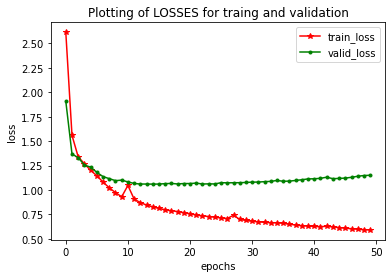

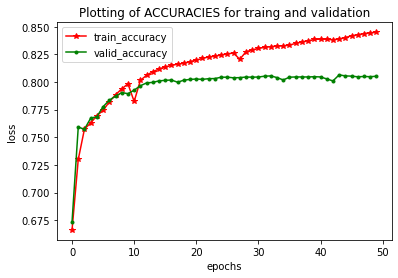

time: 438 ms (started: 2021-06-13 17:09:11 +00:00)


In [ ]:
plt.plot(train_loss_list,"r*-",label="train_loss")
plt.plot(validation_loss_list,"g.-",label="valid_loss")
plt.legend()
plt.title("Plotting of LOSSES for traing and validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

plt.plot(train_accuracy_list,"r*-",label="train_accuracy")
plt.plot(validation_accuracy_list,"g.-",label="valid_accuracy")
plt.legend()
plt.title("Plotting of ACCURACIES for traing and validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

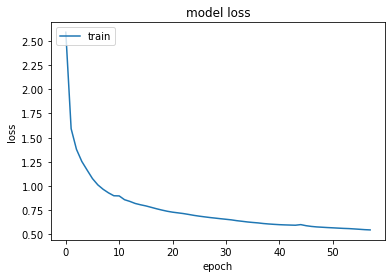

time: 211 ms (started: 2021-06-10 07:32:31 +00:00)


In [ ]:
## in the previos training (only training was besing done)

# summarize history for loss
plt.plot(train_loss_list)
# plt.plot(train_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing the model

## Greedy Search Function

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final
  

time: 14.5 ms (started: 2021-06-13 16:39:39 +00:00)


## Predicting Captions on Test Set using Greedy Search

In [ ]:
# below shells are not run after  the newly last trained model

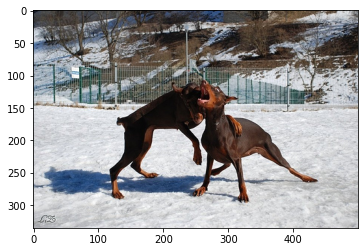

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog play in the snow .
bleu score:  1.0


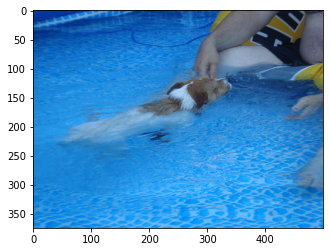

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A person be in a pool .
bleu score:  0.43564355400687105


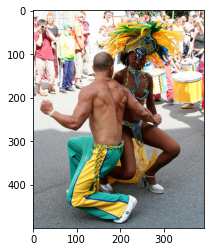

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A shirtless man in a blue shirt be sit on a street with a sign in the background .
bleu score:  0.4234885228074744


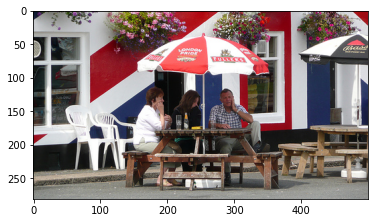

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be pull a red leash on a joust road .
bleu score:  0.7391898294044948


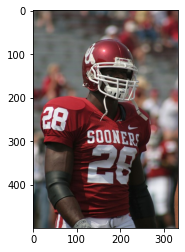

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red and white uniform be wear a red and white helmet .
bleu score:  0.37184214350816


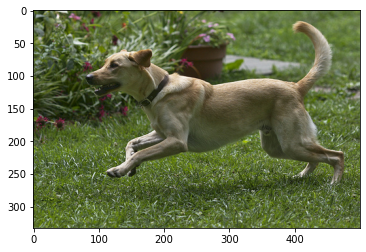

Referance Captions: 
A brown dog run
A brown dog run over grass .
A brown dog with its front paw off the ground on a grassy surface near red and purple flower .
A dog run across a grassy lawn near some flower .
A yellow dog be play in a grassy area near flower .
Predicted Caption: 
A dog be run through the grass .
bleu score:  0.7825422900366437


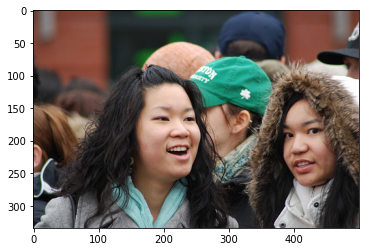

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
A girl with dark brown hair and eye in a blue scarf be stand next to a girl in a fur edge coat .
an Asian boy and an Asian girl be smile in a crowd of person .
Girl be in a crowd .
Two dark haired girl be in a crowd .
Two girl be look past each other in different direction while stand in a crowd .
Predicted Caption: 
A girl in a pink sweatshirt and a hat and a hat and a hat and a hat .
bleu score:  0.2534743707366162


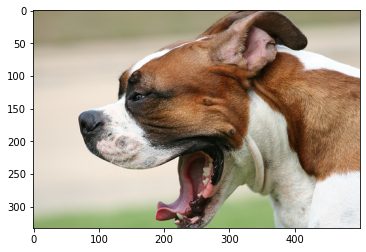

Referance Captions: 
A dog with its mouth open .
Brown and white dog yawn .
Closeup of dog in profile with mouth open .
Dog yawn
A dog 's mouth be open like he be yawn .
Predicted Caption: 
A brown dog with a nose wide wide open .
bleu score:  0.5773502691896257


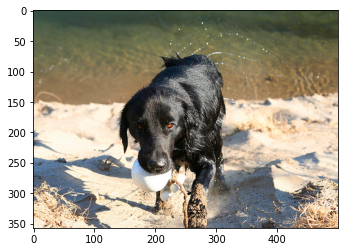

Referance Captions: 
A black dog emerge from the water onto the sand , hold a white object in its mouth .
A black dog emerge from the water with a white ball in its mouth .
A black dog on a beach carry a ball in its mouth .
a black dog walk out of the water with a white ball in his mouth .
Black dog jump out of the water with something in its mouth .
Predicted Caption: 
A black dog be dig in the water with a stick in its mouth .
bleu score:  0.40484119186599643


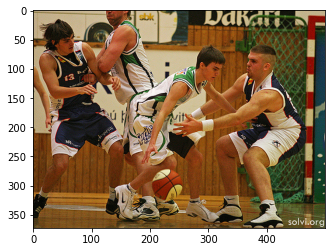

Referance Captions: 
A player from white and green highschool team dribble down court defend by a player from the other team .
Four basketball player in action .
Four man play basketball , two from each team .
Two boy in green and white uniform play basketball with two boy in blue and white uniform .
Young man play basketball in a competition .
Predicted Caption: 
A basketball player in white be challenge a ball .
bleu score:  0.37342112655242105
time: 1min 16s (started: 2021-06-10 05:35:21 +00:00)


In [ ]:
# after completeing traing+VALIDATION ON 12/06/2021   that is TOTAL 50 EPOCHS


all_images="/content/drive/MyDrive/BDA2020_MN/MAHENDRA_DATASET/Flickr8k_Dataset/Flicker8k_Dataset/"

i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(all_images + "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Greedy Search

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<12:32,  1.33it/s]

  0%|          | 2/1000 [00:01<11:46,  1.41it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 3/1000 [00:02<15:35,  1.07it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 4/1000 [00:03<15:40,  1.06it/s]

  0%|          | 5/1000 [00:05<17:44,  1.07s/it]

  1%|          | 6/1000 [00:05<15:37,  1.06it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.war


Bleu score on Greedy search
Score:  0.46364118940857635
time: 17min 3s (started: 2021-06-10 05:51:50 +00:00)


## Beam Search Function

In [ ]:
def beam_search(photo,k):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
  sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
  y_pred = model.predict([photo,sequence],verbose=0)
  predicted=[]
  y_pred=y_pred.reshape(-1)
  for i in range(y_pred.shape[0]):
    predicted.append((i,y_pred[i]))
  predicted=sorted(predicted,key=lambda x:x[1])[::-1]
  b_search=[]
  for i in range(k):
    word = indices_to_words[predicted[i][0]]
    b_search.append((in_text +' ' + word,predicted[i][1]))
    
  for idx in range(max_length):
    b_search_square=[]
    for text in b_search:
      if text[0].split(" ")[-1]=="<end>":
        break
      sequence = [words_to_indices[s] for s in text[0].split(" ") if s in words_to_indices]
      sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
      y_pred = model.predict([photo,sequence],verbose=0)
      predicted=[]
      y_pred=y_pred.reshape(-1)
      for i in range(y_pred.shape[0]):
        predicted.append((i,y_pred[i]))
      predicted=sorted(predicted,key=lambda x:x[1])[::-1]
      for i in range(k):
        word = indices_to_words[predicted[i][0]]
        b_search_square.append((text[0] +' ' + word,predicted[i][1]*text[1]))
    if(len(b_search_square)>0):
      b_search=(sorted(b_search_square,key=lambda x:x[1])[::-1])[:5]
  final=b_search[0][0].split()
  final = final[1:-1]
  #final=" ".join(final)
  return final

time: 48 ms (started: 2021-06-10 06:21:33 +00:00)


## Predicting Captions on Test Set using Beam Search with k=3

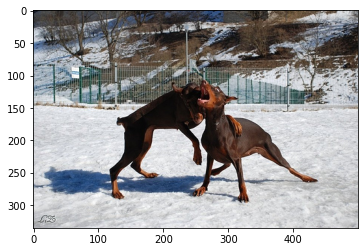

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
Two dog play in the snow .
bleu score:  1.0


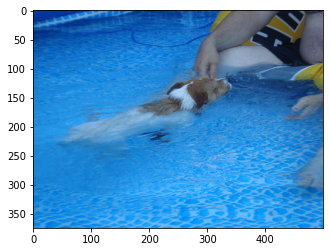

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A person in a blue shirt be play in the middle of a pool .
bleu score:  0.31535540524901323


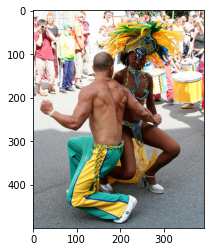

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
A man and a woman in festive costume dance .
A man and a woman with feather on her head dance .
A man and a woman wear decorative costume and dance in a crowd of onlooker .
one performer wear a feathered headdress dance with another performer in street
Two person be dance with drum on the right and a crowd behind them .
Predicted Caption: 
A shirtless man in a blue shirt be sit on a street .
bleu score:  0.4900941039306948


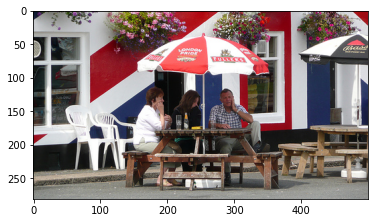

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Referance Captions: 
A couple of person sit outdoors at a table with an umbrella and talk .
Three person be sit at an outside picnic bench with an umbrella .
Three person sit at an outdoor cafe .
Three person sit at an outdoor table in front of a building paint like the Union Jack .
Three person sit at a picnic table outside of a building paint like a union jack .
Predicted Caption: 
A man be pull a red leash on an obstacle course .
bleu score:  0.7391898294044948


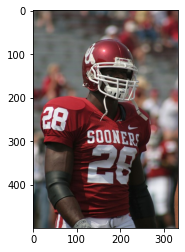

Referance Captions: 
A man be wear a Sooner red football shirt and helmet .
A Oklahoma Sooner football player wear his jersey number 28 .
A Sooner football player weas the number 28 and black armband .
Guy in red and white football uniform
The American footballer be wear a red and white strip .
Predicted Caption: 
A football player in a red and white uniform and a red helmet and a red and white and white helmet .
bleu score:  0.1582128588834926


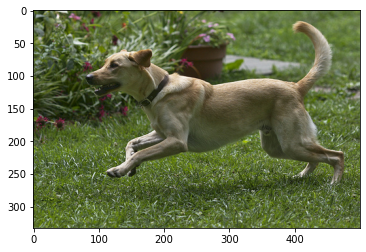

Referance Captions: 
A brown dog run
A brown dog run over grass .
A brown dog with its front paw off the ground on a grassy surface near red and purple flower .
A dog run across a grassy lawn near some flower .
A yellow dog be play in a grassy area near flower .
Predicted Caption: 
A dog run through the grass .
bleu score:  0.5410822690539396


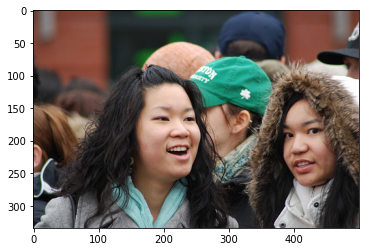

Referance Captions: 
A girl with dark brown hair and eye in a blue scarf be stand next to a girl in a fur edge coat .
an Asian boy and an Asian girl be smile in a crowd of person .
Girl be in a crowd .
Two dark haired girl be in a crowd .
Two girl be look past each other in different direction while stand in a crowd .
Predicted Caption: 
A group of girl in colorful clothing , and a crowd of direction .
bleu score:  0.3104607827452042


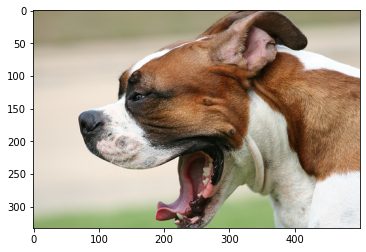

Referance Captions: 
A dog with its mouth open .
Brown and white dog yawn .
Closeup of dog in profile with mouth open .
Dog yawn
A dog 's mouth be open like he be yawn .
Predicted Caption: 
A brown and white dog lick its nose .
bleu score:  0.392814650900513


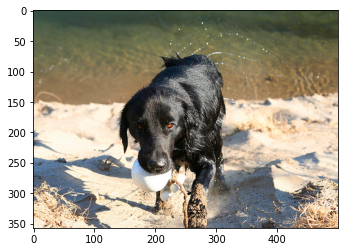

Referance Captions: 
A black dog emerge from the water onto the sand , hold a white object in its mouth .
A black dog emerge from the water with a white ball in its mouth .
A black dog on a beach carry a ball in its mouth .
a black dog walk out of the water with a white ball in his mouth .
Black dog jump out of the water with something in its mouth .
Predicted Caption: 
A black dog be dig in the surf .
bleu score:  0.25186505044536794


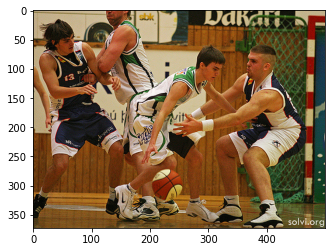

Referance Captions: 
A player from white and green highschool team dribble down court defend by a player from the other team .
Four basketball player in action .
Four man play basketball , two from each team .
Two boy in green and white uniform play basketball with two boy in blue and white uniform .
Young man play basketball in a competition .
Predicted Caption: 
A basketball player in white be challenge a player in white for the basket .
bleu score:  0.2714744280573552
time: 48 s (started: 2021-06-10 06:21:48 +00:00)


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread(all_images + "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==10):
    break

## Calculating Average Bleu Score on Test Set using Beam Search with k=3

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=beam_search(photo,3)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Beam search with k=3")
print("Score: ",avg_score)



  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:02<40:03,  2.41s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 2/1000 [00:07<55:40,  3.35s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 3/1000 [00:13<1:04:16,  3.87s/it]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  0%|          | 4/1000 [00:17<1:07:28,  4.06s/it]

  0%|          | 5/1000 [00:25<1:28:36,  5.34s/it]

  1%|          | 6/1000 [00:28<1:1


Bleu score on Beam search with k=3
Score:  0.4819755860086666
time: 1h 8min 35s (started: 2021-06-10 06:23:51 +00:00)


In [ ]:
## You should practice once all the codes. You perhaps followed that brfor entering Training part 
## I showed some visualization of trainig anf validation loss. DOnt be confused for that. 